<a href="https://colab.research.google.com/github/TAUforPython/machinelearning/blob/main/NN%20LSTM%20tabular%20data%20ECG%20classificatio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install --upgrade --force-reinstall --quiet gensim

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


TypeError: kill() takes exactly 2 arguments (1 given)

In [ ]:
import os
os.kill(0,9)

In [1]:
# Импорт необходимых библиотек.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from gensim.models import Word2Vec

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Bidirectional, LSTM, Dense, Masking, Dropout, GlobalMaxPooling1D, GlobalAveragePooling1D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
import tensorflow as tf

In [2]:
# -------------------------------
# Загрузка и предобработка данных
# -------------------------------

# Читаем данные из CSV файла.
file_link = "https://github.com/TAUforPython/BioMedAI/raw/refs/heads/main/test_datasets/test_data_ECG.csv"
#data = pd.read_csv('test_data_ECG.csv')
data = pd.read_csv(file_link)

# Убираем лишние пробелы в названиях колонок, чтобы не возникало ошибок при обращении к ним.
data = data.rename(columns=lambda x: x.strip())

# Сохраняем исходные данные в переменной clear_data для последующей работы.
clear_data = data.copy()

#_______________________________________________________________________________
#Обрабатываем текстовые описания репортов
reports = [f'report_{x}' for x in range(18)]
clear_data['report_0'] = clear_data[reports].astype(str).agg(' '.join, axis=1)
clear_data['report_0'] = clear_data['report_0'].str.replace(r'\bnan\b', '', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()
clear_data.rename(columns={'report_0': 'report'}, inplace=True)
reports_to_drop = [f'report_{x}' for x in range(1, 18)]
clear_data = clear_data.drop(reports_to_drop, axis=1)

# Превращаем столбец с текстовым отчетом в число с помощью Word2Vec
words = [text.split() for text in clear_data['report']] # Разбиваем  на токены
w2v_model = Word2Vec(words, vector_size=100, window=5, min_count=1, workers=4) # Обучаем модель Word2Vec
def get_sentence_embedding(sentence): # Функция для получения среднего эмбеддинга строки
    words = sentence.split()
    word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)  # Усреднённый вектор
    else:
        return np.zeros(w2v_model.vector_size)  # Нулевой вектор, если слова нет в модели

clear_data['report'] = clear_data['report'].apply(lambda x: get_sentence_embedding(x).mean()) # Применяем функцию ко всей колонке и переводим каждый вектор в одно число
clear_data['report'] = clear_data['report'].apply(lambda x: abs(x))
#_______________________________________________________________________________

# Преобразуем дату и время в единый формат.
# Объединяем столбцы 'eeg_date' и 'eeg_time' и конвертируем их в формат datetime.
clear_data['eeg_datetime'] = pd.to_datetime(clear_data['eeg_date'] + ' ' + clear_data['eeg_time'],
                                            errors='coerce', dayfirst=True)
# Удаляем исходные столбцы с датой и временем, так как теперь они не нужны.
clear_data = clear_data.drop(columns=['eeg_date', 'eeg_time'])

# Приводим числовые признаки к числовому типу.
# Определяем список признаков ЭКГ.
numeric_columns = ['report', 'rr_interval', 'p_onset', 'p_end', 'qrs_onset',
                   'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis']
clear_data[numeric_columns] = clear_data[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Убираем аномальные значения: значения признаков больше 2000 считаем аномальными,
# а также удаляем строки с логически неверными соотношениями (p_onset < p_end и qrs_onset < qrs_end).
clear_data = clear_data[(clear_data[numeric_columns] < 2000).all(axis=1)]
clear_data = clear_data[(clear_data['p_onset'] < clear_data['p_end']) & (clear_data['qrs_onset'] < clear_data['qrs_end'])]

# Сортируем данные по идентификатору пациента (subject_id) и времени обследования.
# Это важно для формирования корректных временных рядов.
clear_data = clear_data.sort_values(by=['subject_id', 'eeg_datetime'])


In [3]:
clear_data.head()

,subject_id,Count_subj,study_id,cart_id,Healthy_Status,report,bandwidth,filtering,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,eeg_datetime
4448,10001877,4,40056908,6919786,0,0.029691,0.005-150 Hz,60 Hz notch Baseline filter,1034,40,120,152,248,568,-45,28,-18,2014-06-27 10:32:00
8586,10002155,13,40107403,6578848,0,0.013311,0.05-150 Hz,60 Hz notch Baseline filter,983,40,148,212,306,622,14,19,5,2010-09-29 10:15:00
1917,10002221,13,40024801,6903271,0,0.029449,0.005-150 Hz,Baseline filter,769,40,134,268,350,704,39,-3,78,2015-04-12 04:14:00
3849,10003757,2,40049308,6672155,0,0.001548,0.005-150 Hz,60 Hz notch Baseline filter,759,40,156,212,318,614,49,-7,125,2011-09-22 19:02:00
8139,10004422,7,40102219,6228095,0,0.011745,0.005-150 Hz,60 Hz notch Baseline filter,769,40,126,184,320,618,54,-58,60,2010-01-05 03:58:00


In [4]:
# -------------------------------
# Формирование временных рядов и нормализация
# -------------------------------

# Для каждого пациента (subject_id) формируем последовательность обследований.
# Каждая последовательность – это временной ряд, состоящий из строк с числовыми признаками ЭКГ.
# В качестве целевой метки выбирается последний зафиксированный Healthy_Status (0 — здоров, 1 — болен).
sequence_data = []
sequence_labels = []
features = numeric_columns  # Используем только числовые признаки ЭКГ.

for subject_id, group in clear_data.groupby('subject_id'):
    group_features = group[features].values  # Получаем данные в виде матрицы (seq_len, num_features)
    label = group['Healthy_Status'].values[-1]  # Берём последнюю метку пациента.
    sequence_data.append(group_features)
    sequence_labels.append(label)

# Нормализация данных:
# Объединяем все последовательности для вычисления среднего и стандартного отклонения.
all_data = np.vstack(sequence_data)
scaler = StandardScaler().fit(all_data)

# Применяем scaling к каждой последовательности индивидуально.
sequence_data_scaled = [scaler.transform(seq) for seq in sequence_data]

# Приводим все последовательности к одной длине с помощью паддинга.
# Определяем максимальную длину последовательности.
max_seq_length = max(len(seq) for seq in sequence_data_scaled)
# Используем pad_sequences для дополнения коротких последовательностей нулями (padding='post').
X = pad_sequences(sequence_data_scaled, maxlen=max_seq_length, dtype='float32', padding='post', truncating='post')
y = np.array(sequence_labels)

print("Форма входных данных:", X.shape)   # (num_patients, max_seq_length, num_features)
print("Форма меток:", y.shape)              # (num_patients,)

# Разбиваем данные на обучающую и тестовую выборки (90% на обучение, 10% на тест).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Вычисляем веса классов для компенсации дисбаланса в данных.
# Это помогает модели уделять больше внимания редкому классу.
weights = class_weight.compute_class_weight(class_weight='balanced',
                                            classes=np.unique(y_train),
                                            y=y_train)
class_weights = {i: weights[i] for i in range(len(weights))}
print("Классовые веса:", class_weights)


Форма входных данных: (6575, 4, 10)
Форма меток: (6575,)
Классовые веса: {0: 0.6990784499054821, 1: 1.755786350148368}


In [5]:
# -------------------------------
# Построение модели (Conv1D + Bidirectional LSTM + Глобальное объединение)
# -------------------------------

# Используем функциональный API для объединения нескольких глобальных пулов.
inputs = Input(shape=(max_seq_length, len(features)))

# Слой Masking – игнорирует паддинговые (нулевые) значения.
x = Masking(mask_value=0.)(inputs)

# Сверточный блок для выделения локальных особенностей.
x = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)

# Первый слой Bidirectional LSTM – извлекает временные зависимости (возвращает последовательности).
x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))(x)
x = BatchNormalization()(x)

# Второй слой Bidirectional LSTM – извлекает более глубокие зависимости.
x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))(x)
x = Dropout(0.4)(x)

# Глобальное объединение: усреднение по временной оси.
x = GlobalAveragePooling1D()(x)

# Полносвязный слой для дальнейшей обработки извлечённых признаков.
x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

# Выходной слой для бинарной классификации.
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

# Компилируем модель с дополнительными метриками.
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy',
                       tf.keras.metrics.Precision(name='precision'),
                       tf.keras.metrics.Recall(name='recall'),
                       tf.keras.metrics.AUC(name='auc')])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 4, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ masking (Masking)               │ (None, 4, 10)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 4, 64)          │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 4, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 4, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 4, 128)         │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 373,825 (1.43 MB)

 Trainable params: 373,057 (1.42 MB)

 Non-trainable params: 768 (3.00 KB)

In [6]:
# -------------------------------
# Обучение модели
# -------------------------------
epochs = 50
batch_size = 32

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test), #смотрим метрики по тестовым данным
                    epochs=epochs,
                    batch_size=batch_size,
                    class_weight=class_weights,
                    callbacks=[early_stop, reduce_lr],
                    verbose=1)


Epoch 1/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 36s 72ms/step - accuracy: 0.7198 - auc: 0.8185 - loss: 0.6566 - precision: 0.5084 - recall: 0.8116 - val_accuracy: 0.7888 - val_auc: 0.9014 - val_loss: 0.5608 - val_precision: 0.8793 - val_recall: 0.2787 - learning_rate: 0.0010
Epoch 2/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.8310 - auc: 0.9106 - loss: 0.4690 - precision: 0.6528 - recall: 0.8679 - val_accuracy: 0.8647 - val_auc: 0.9292 - val_loss: 0.4100 - val_precision: 0.6992 - val_recall: 0.9016 - learning_rate: 0.0010
Epoch 3/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.8572 - auc: 0.9294 - loss: 0.4107 - precision: 0.6977 - recall: 0.8981 - val_accuracy: 0.8860 - val_auc: 0.9393 - val_loss: 0.3846 - val_precision: 0.7411 - val_recall: 0.9071 - learning_rate: 0.0010
Epoch 4/50
185/185 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.8609 - auc: 0.9309 - loss: 0.3973 - precision: 0.7094 - recall: 0.8918 - val_accuracy: 0.8891 - val_auc: 0.9417 - val_loss: 0.376

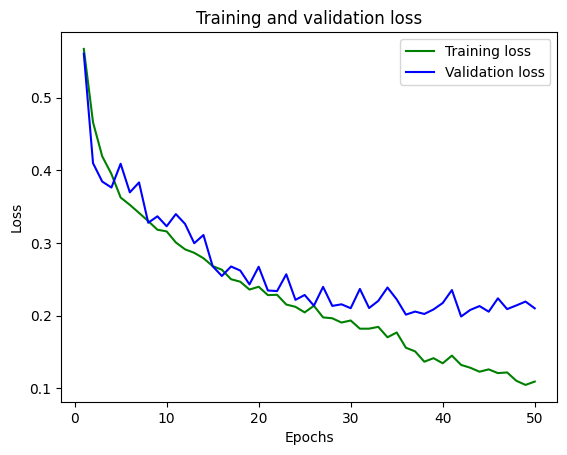

In [7]:
# Строим график обучения и контролируем val и train loss
loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, validation_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
# -----------------------------------------------
# Оцениваем переобучение
# -----------------------------------------------
train_metrics = model.evaluate(X_train, y_train, verbose=0)
test_metrics = model.evaluate(X_test, y_test, verbose=0)

print("\n Оценка переобучения")
print("----------------------------------")
print("Метрики на обучающем наборе:")
for name, value in zip(model.metrics_names, train_metrics):
    print(f"{name}: {value:.4f}")

print("\nМетрики на тестовом наборе:")
for name, value in zip(model.metrics_names, test_metrics):
    print(f"{name}: {value:.4f}")

train_loss = train_metrics[0]
test_loss = test_metrics[0]
loss_diff = test_loss - train_loss
print("\nРазница в потере (Test loss - Train loss): {:.4f}".format(loss_diff))


 Оценка переобучения
----------------------------------
Метрики на обучающем наборе:
loss: 0.1019
compile_metrics: 0.9643

Метрики на тестовом наборе:
loss: 0.1988
compile_metrics: 0.9422

Разница в потере (Test loss - Train loss): 0.0969


In [9]:
# -------------------------------
# Оценка модели и оптимизация порога отсечения
# -------------------------------

# Получаем предсказания вероятностей для тестовой выборки.
y_pred_prob = model.predict(X_test).reshape(-1)

# По умолчанию порог = 0.5. Найдём оптимальный порог, максимизирующий F1-score.
best_threshold = 0.5
best_f1 = 0
for thresh in np.arange(0.3, 0.71, 0.01):
    y_pred_temp = (y_pred_prob >= thresh).astype(int)
    temp_f1 = f1_score(y_test, y_pred_temp)
    if temp_f1 > best_f1:
        best_f1 = temp_f1
        best_threshold = thresh

print(f"Оптимальный порог: {best_threshold:.2f} с F1: {best_f1:.4f}")

# Вычисляем метрики с оптимальным порогом.
y_pred = (y_pred_prob >= best_threshold).astype(int)
test_accuracy = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_auc = roc_auc_score(y_test, y_pred)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")
print(f"Test AUC-ROC: {test_auc:.4f}")


21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step
Оптимальный порог: 0.70 с F1: 0.9264
Test Accuracy: 0.9590
Test Precision: 0.9239
Test Recall: 0.9290
Test F1 Score: 0.9264
Test AUC-ROC: 0.9497


Text(0.5, 1.0, 'Ensemble Classification Report')

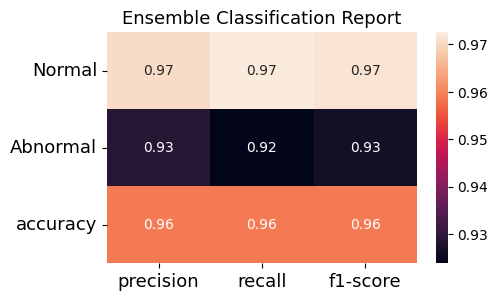

In [10]:
# упростим задачу - переходим к бинарной классификации - назначаем норму и ненорму на классы
# оцениваем как модель справляется с каждым классом
id_to_label = {
    0: "Normal",   # "условно-здоровый"
    1: "Abnormal", # "риск отклонений от нормы здоровья"
}

# формируем отчет по классификации
clf_report = classification_report(y_pred,
                                   y_test,
                                   labels=[0,1],
                                   target_names=list(id_to_label.values()),
                                   output_dict=True)

# в отчет по классам выводим метрики
plt.figure(figsize=(5, 3))
ax = sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :-2].T, annot=True)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=13)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=13, rotation=0)
plt.title("Ensemble Classification Report", fontsize=13)

In [11]:
# -------------------------------
# Пример предсказания для нового пациента
# -------------------------------

# Задаём данные нового пациента в виде двумерного массива (2 обследования, 9 признаков).
new_patient_data = np.array([[0.023522, 700, 40, 120, 160, 240, 500, 80, 75, 78],
                             [0.022433, 710, 40, 118, 165, 245, 510, 82, 76, 77]])  # форма: (2, num_features)

# Применяем ту же нормализацию к новым данным.
new_patient_data_scaled = scaler.transform(new_patient_data)
# Приводим последовательность нового пациента к длине, используемой моделью, с помощью паддинга.
new_patient_data_padded = pad_sequences([new_patient_data_scaled], maxlen=max_seq_length, dtype='float32',
                                         padding='post', truncating='post')
# Получаем предсказание: вероятность того, что пациент находится в критическом состоянии (1 - болен).
prediction_prob = model.predict(new_patient_data_padded)[0][0]
print("Вероятность критического состояния (1 - болен):", prediction_prob)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
Вероятность критического состояния (1 - болен): 0.01750043
